## Predictive models
Analyses concerning the relation between linguistic features and engagement.

In [1]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl
import xgboost
import shap
from src.colnames import topic_col, style_col

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

### Results of predictive models

Visualizing performance in terms of R^2, MSE, and MAE

In [9]:
d = json.load(open('logs/engagement/perf.json'))

In [10]:
d

[{'train_mse': 253092.24739980136,
  'train_mae': 156.8259878192268,
  'train_r2': 0.3298340988280952,
  'val_mse': 307933.26572959137,
  'val_mae': 168.83709380313846,
  'val_r2': 0.09380611172605091,
  'test_mse': 225194.61672553624,
  'test_mae': 158.20003274982741,
  'test_r2': 0.20379481769704122,
  'model': 'combined'}]

Computing rank correlations between predictions and true engagement values (gives an idea of how well the model understands which tweets will get more attention, without its predictions being necessarily numerically accurate)

In [17]:
dfs = []
# for metric in ['sum']:
fs = glob.glob(f'logs/engagement/results/pred*.pkl')
for f in fs:
    f_df = pd.read_pickle(f)
    f_df['metric'] = 'sum_count'
    dfs.append(f_df)
metrics = pd.concat(dfs, ignore_index=True)

In [20]:
metrics

,trial_id,label,prediction,model_name,split,metric
0,Congratulations to the winners of Juvenes @tra...,24,35.521191,combined,test,sum_count
1,Do you #commute between 2 EU countries?Find ou...,14,31.164579,combined,test,sum_count
2,Watch live - President @BarrosoEU speech at LS...,31,77.801544,combined,test,sum_count
3,Preparation of #Economic and #Finance Minister...,10,27.544012,combined,test,sum_count
4,.@BarrosoEU to speak tomorrow at @LSEpubliceve...,7,40.152374,combined,test,sum_count
...,...,...,...,...,...,...
29101,Commission launches public #consultation on th...,6,21.568872,combined,val,sum_count
29102,Commission doubles its #humanitarian assistanc...,7,41.181877,combined,val,sum_count
29103,Digital Agenda: technical rules agreed for usi...,15,44.286259,combined,val,sum_count
29104,Commission welcomes Court judgment on #Visa's ...,4,39.862659,combined,val,sum_count


In [21]:
spears = metrics.groupby(['metric', 'split',
                          'model_name'])[['label', 
                                          'prediction']].apply(lambda x: x.corr('spearman').iloc[0,1]).reset_index()
spears = spears.rename({0: 'spearman_cor'}, axis=1)

In [22]:
spears

,metric,split,model_name,spearman_cor
0,sum_count,test,combined,0.717201
1,sum_count,train,combined,0.705504
2,sum_count,val,combined,0.703186


Load the model and SHAP values

In [29]:
with xgboost.config_context(verbosity=0):
    m = f'logs/engagement/results/model.pkl'
    name = m.split('/')[-1]
    model = pkl.load(open(m, 'rb'))
    feature_names = topic_col + style_col
    df = pd.DataFrame(zip(model.feature_importances_,
                          feature_names), 
                      columns=['importance', 'feature'])
    df = df.sort_values(by='importance')
    shaps = pkl.load(open(f'logs/engagement/results/shap.pkl','rb'))
    shaps.feature_names = feature_names

Visualize model parameters

In [30]:
model.get_xgb_params()

{'objective': 'reg:tweedie',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.2,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 3,
 'max_leaves': 0,
 'min_child_weight': 5,
 'monotone_constraints': '()',
 'n_jobs': 20,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 5.0,
 'reg_lambda': 0,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'tweedie_variance_power': 1.3}

Process SHAP values and visualize

In [31]:
shaps_df = pd.DataFrame(shaps.values.T)
shaps_df['feature_name'] = feature_names
shaps_long = shaps_df.melt(id_vars='feature_name')
norm_data = RobustScaler().fit_transform(shaps.data)
shaps_df_data = pd.DataFrame(norm_data.T)
shaps_df_data['feature_name'] = feature_names
shaps_long_data = shaps_df_data.melt(id_vars='feature_name')
shaps_long['data'] = shaps_long_data['value']
shaps_long['data_simple'] = np.select([(shaps_long['data']<0), 
                                       (shaps_long['data']==0), 
                                       (shaps_long['data']>0)], 
                                      ['low', 'zero', 'high'])

In [32]:
sort_shaps = shaps_long.groupby('feature_name')['value'].agg(lambda x: x.abs().mean()).reset_index().sort_values('value',
                                                                                                                 ascending=False)

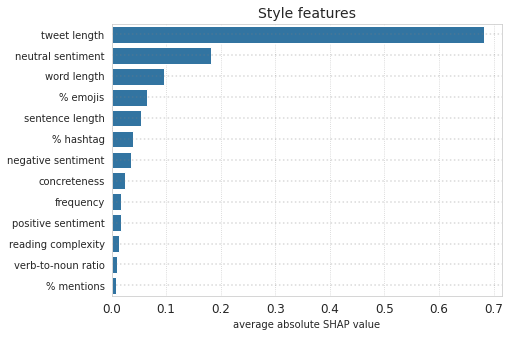

In [34]:
plt.subplots(figsize=(7,5))
for i in range(len(style_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
sns.barplot(data=sort_shaps[sort_shaps['feature_name'].isin(style_col)],
            x='value', y='feature_name', color=sns.color_palette()[0])
plt.xlabel('average absolute SHAP value')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Style features', fontsize=14)
plt.savefig('figs/xgb/style_imp.png', dpi=300, bbox_inches='tight')

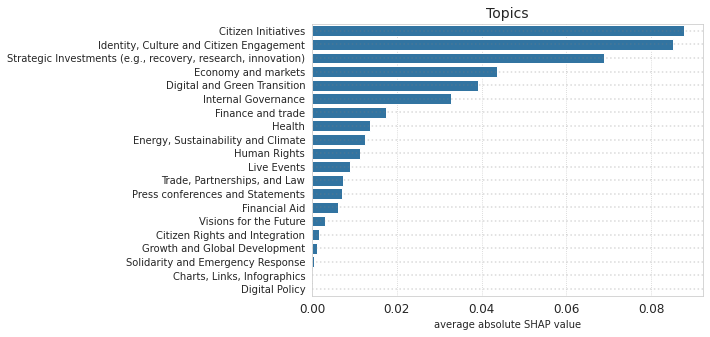

In [36]:
plt.subplots(figsize=(7,5))
for i in range(len(topic_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
sns.barplot(data=sort_shaps[sort_shaps['feature_name'].isin(topic_col)],
            x='value', y='feature_name', color=sns.color_palette()[0])
plt.xlabel('average absolute SHAP value')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Topics', fontsize=14)
plt.savefig('figs/xgb/topic_imp.png', dpi=300, bbox_inches='tight')

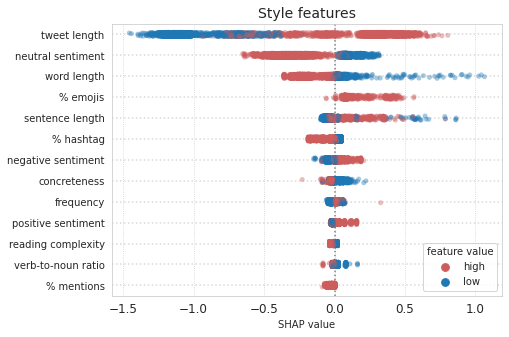

In [37]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plt.subplots(figsize=(7,5))
data = shaps_long[shaps_long['feature_name'].isin(style_col)]
data = data.merge(sort_shaps, on='feature_name').sort_values(by='value_y', ascending=False)
for i in range(len(style_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
plt.axvline(0, color='grey', linestyle='dotted')
sns.stripplot(data=data,
             y='feature_name', x='value_x', 
                hue='data_simple', palette=['indianred', 
                                            sns.color_palette()[0]],
                hue_order=['high', 'low'],
                alpha=.4)
plt.legend(title='feature value', loc='lower right')
plt.ylabel('')
plt.xlabel('SHAP value')
plt.xticks(fontsize=12)
plt.title('Style features', fontsize=14)
plt.savefig('figs/xgb/style_SHAP.png', dpi=300, bbox_inches='tight')
plt.show()

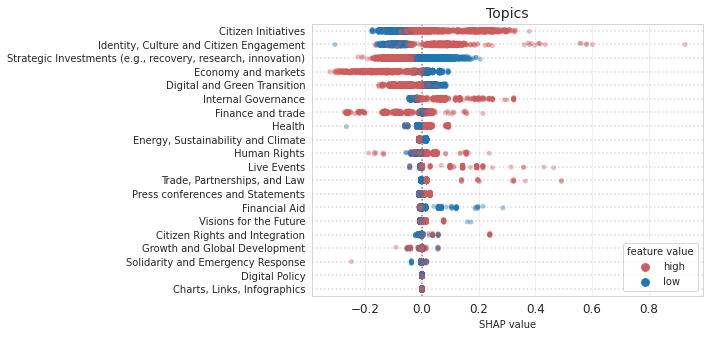

In [38]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plt.subplots(figsize=(7,5))
data = shaps_long[shaps_long['feature_name'].isin(topic_col)]
data = data.merge(sort_shaps, on='feature_name').sort_values(by='value_y', ascending=False)
for i in range(len(topic_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
plt.axvline(0, color='grey', linestyle='dotted')
sns.stripplot(data=data[data['data_simple']!='zero'],
             y='feature_name', x='value_x', 
             hue='data_simple', palette={'high': 'indianred',
                                         'low': sns.color_palette()[0]},
             alpha=.4)
plt.legend(title='feature value', loc='lower right')
plt.ylabel('')
plt.xlabel('SHAP value')
plt.xticks(fontsize=12)
plt.title('Topics', fontsize=14)

plt.savefig('figs/xgb/topic_SHAP.png', dpi=300, bbox_inches='tight')
plt.show()